In [1]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
class ConfigSIS:
    T = 100.0
    T_unit = 0.01
    N = int(T / T_unit)
    S_start = 50.0  # 99.0
    I_start = 49.0 # 1.0
    R_start = 1.0 # 0.0
    NN = S_start + I_start + R_start
    beta = 0.4  # 0.01
    gamma = 0.04 # 0.05
    ub = T
    lb = 0.0
    mu = 0.03
    lam = mu * NN

class SimpleNetworkSIS(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkSIS, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkSIS"
        self.sig = nn.Tanh()

        # Design A
        # self.fc1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(100, 100),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(100, 100),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(100, 1),
        #     # 'sig4': nn.ReLU()
        # }))

        # self.fc2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(100, 100),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(100, 100),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(100, 1),
        #     # 'sig4': nn.ReLU()
        # }))

        # self.fc3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(100, 100),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(100, 100),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(100, 1),
        #     # 'sig4': nn.ReLU()
        # }))

        # Design D
        self.fc_x1_0_1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
        }))

        self.fc_x2_0_1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
        }))

        self.fc_x3_0_1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
        }))

        self.fc_x1_1_2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x2_1_2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x3_1_2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x1_2_3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x2_2_3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x3_2_3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x1_3_4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(100, 1),
        }))

        self.fc_x2_3_4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(100, 1),
        }))

        self.fc_x3_3_4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(100, 1),
        }))

    def forward(self, inputs):
        x1, x2, x3 = torch.chunk(inputs, 3, 1)
        # Design A
        # x1_new = self.fc1(x1)
        # x2_new = self.fc2(x2)
        # x3_new = self.fc3(x3)

        # Design D
        x1_1_output = self.fc_x1_0_1(x1)
        x2_1_output = self.fc_x2_0_1(x2)
        x3_1_output = self.fc_x3_0_1(x3)

        x1_2_input = torch.cat((x1_1_output, x2_1_output), 1)
        x2_2_input = torch.cat((x1_1_output, x2_1_output), 1)
        x3_2_input = torch.cat((x2_1_output, x3_1_output), 1)

        x1_2_output = self.fc_x1_1_2(x1_2_input)
        x2_2_output = self.fc_x2_1_2(x2_2_input)
        x3_2_output = self.fc_x3_1_2(x3_2_input)

        x1_3_input = torch.cat((x1_2_output, x2_2_output), 1)
        x2_3_input = torch.cat((x1_2_output, x2_2_output), 1)
        x3_3_input = torch.cat((x2_2_output, x3_2_output), 1)

        x1_3_output = self.fc_x1_2_3(x1_3_input)
        x2_3_output = self.fc_x2_2_3(x2_3_input)
        x3_3_output = self.fc_x3_2_3(x3_3_input)

        x1_new = self.fc_x1_3_4(x1_3_output)
        x2_new = self.fc_x2_3_4(x2_3_output)
        x3_new = self.fc_x3_3_4(x3_3_output)

        outputs = torch.cat((x1_new, x2_new, x3_new), 1)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit, i*self.config.T_unit, i*self.config.T_unit] for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0, -1.0]).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray([self.config.S_start, self.config.I_start, self.config.R_start]).reshape([1, -1])).float().to(self.device)
        self.yend = torch.Tensor(np.asarray([0, 0, 100]).reshape([1, -1])).float().to(self.device)
        self.tend = torch.Tensor(np.asarray([1.0, 1.0, 1.0]).reshape([1, -1])).float().to(self.device)

    def loss(self):
        self.eval()
        y = self.forward(self.x)
        # print("y.shape:", y[:, 0:1].shape)
        # print(y[:, 0:1])
        # print("self.x.shape:", self.x[:, 0:1].shape)
        # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
        s = y[:, 0:1]
        i = y[:, 1:2]
        r = y[:, 2:3]
        # n = s + i + r

        s_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        i_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
        r_t = torch.gradient(y[:, 2:3].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 2:3].reshape([self.config.N]),))[0]

        s_t = s_t.reshape([self.config.N, 1])
        i_t = i_t.reshape([self.config.N, 1])
        r_t = r_t.reshape([self.config.N, 1])
        # print(y_t,u_t)
        f_s = s_t - (- self.config.beta * s * i / self.config.NN + self.config.lam - self.config.mu * s)
        f_i = i_t - (self.config.beta * s * i / self.config.NN - self.config.gamma * i - self.config.mu * i)
        f_r = r_t - (self.config.gamma * i - self.config.mu * r)

        # f_s = s_t - (- self.config.beta * s * i)
        # f_i = i_t - (self.config.beta * s * i - self.config.gamma * i)
        # f_r = r_t - (self.config.gamma * i)



        f_y = torch.cat((f_s, f_i, f_r), 1)
        y0_pred = self.forward(self.t0)
        yend_pred = self.forward(self.tend)
        # print_flag = False  # True # False
        # if print_flag:
        #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
        #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
        #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
        #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
        #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
        #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
        #     print("self.t0 =", self.t0, "self.t0=", self.t0, "self.y0 =", self.y0,
        #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

        # loss_2_weights = [[i, i] for i in range(20000)]  # toy
        # loss_2_weights = np.asarray(loss_2_weights)
        # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

        loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        loss_3 = torch.mean(torch.square((torch.abs(s) - s))) + torch.mean(torch.square((torch.abs(i) - i))) + torch.mean(torch.square((torch.abs(r) - r))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(1.0/((s+1e-6)*(s+1e-6)+1e-6))) + torch.mean(torch.square(1.0/((i+1e-6)*(i+1e-6)+1e-6))) + torch.mean(torch.square(1.0/((r+1e-6)*(r+1e-6)+1e-6)))
        
        # loss_3 = torch.mean(torch.square(1/(u*u+v*v)))
        # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
        #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
        # loss_3 = 10 * (torch.abs(torch.sum(y0_pred) - self.config.SIR_sum) + torch.abs(torch.sum(yend_pred) - self.config.SIR_sum))
        loss = loss_1 + loss_2
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_3]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [ ]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def train_sis(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        loss, loss_list = model.loss()
        loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        best_loss = 999999
        if epoch % epoch_step == 0:
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_sis(model, args, config, now_string, True)

def test_sis(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    s, i, r = torch.chunk(y, 3, 1)
    # print("u=", u)
    # print("v=", v)
    s = [item[0] for item in s.cpu().detach().numpy()]
    i = [item[0] for item in i.cpu().detach().numpy()]
    r = [item[0] for item in r.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    pairs = [[ss, ii, rr, xx] for ss, ii, rr, xx in zip(s, i, r, x)]
    pairs.sort(key=lambda xx: xx[-1])
    s = [item[0] for item in pairs]
    i = [item[1] for item in pairs]
    r = [item[2] for item in pairs]
    x = [item[3] for item in pairs]
    print("s=", s[:10], "...", s[-10:])
    print("i=", i[:10], "...", i[-10:])
    print("r=", r[:10], "...", r[-10:])
    print("x=", x[:10], "...", x[-10:])
    plt.plot(x, s, marker='.', markersize=0.2, linewidth=0.1, c="b")
    plt.plot(x, i, marker='.', markersize=0.2, linewidth=0.1, c="r")
    plt.plot(x, r, marker='.', markersize=0.2, linewidth=0.1, c="g")
    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    plt.savefig(figure_save_path, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()
    print("Saved as {}".format(figure_save_path))

class Args:
  epoch = 200
  epoch_step = 10
  lr = 0.001
  main_path = "."
  save_step = 100

def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

def run_sis(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigSIS
    model = SimpleNetworkSIS(config).to(device)
    train_sis(model, args, config, now_string)
    model = SimpleNetworkSIS(config).to(device)
    test_sis(model, args, config, now_string)

In [ ]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_sis(main_path)

using cuda
epoch = 200
epoch_step = 10
model_name = SimpleNetworkSIS
now_string = 2022-04-05-04-23-59
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy
Epoch [00010/00200] Loss:4.385890 Loss_1:0.993828 Loss_2:3.392061 Loss_3:0.000000 Lr:0.000990 Time:20.769258s (0.35min in total)
Epoch [00020/00200] Loss:0.537250 Loss_1:0.001285 Loss_2:0.535965 Loss_3:0.000000 Lr:0.000980 Time:21.398914s (0.70min in total)
Epoch [00030/00200] Loss:0.199641 Loss_1:0.000367 Loss_2:0.199275 Loss_3:0.000000 Lr:0.000971 Time:21.223898s (1.06min in total)
Epoch [00040/00200] Loss:0.028498 Loss_1:0.000046 Loss_2:0.028452 Loss_3:0.000000 Lr:0.000962 Time:24.785387

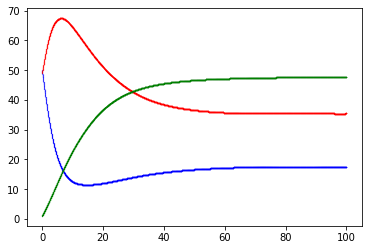

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_1649132828.png


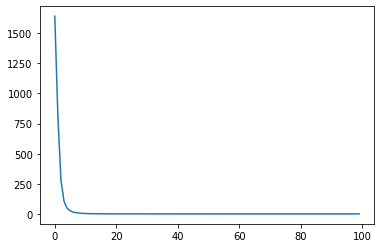

Epoch [00110/00200] Loss:0.000316 Loss_1:0.000001 Loss_2:0.000315 Loss_3:0.000000 Lr:0.000901 Time:8.971978s (3.30min in total)
Epoch [00120/00200] Loss:0.000314 Loss_1:0.000002 Loss_2:0.000313 Loss_3:0.000000 Lr:0.000893 Time:7.095406s (3.41min in total)
Epoch [00130/00200] Loss:0.000313 Loss_1:0.000002 Loss_2:0.000310 Loss_3:0.000000 Lr:0.000885 Time:10.209145s (3.58min in total)
Epoch [00140/00200] Loss:0.000312 Loss_1:0.000002 Loss_2:0.000309 Loss_3:0.000000 Lr:0.000877 Time:9.002768s (3.73min in total)
Epoch [00150/00200] Loss:0.000310 Loss_1:0.000002 Loss_2:0.000308 Loss_3:0.000000 Lr:0.000870 Time:8.333244s (3.87min in total)
Epoch [00160/00200] Loss:0.000310 Loss_1:0.000002 Loss_2:0.000308 Loss_3:0.000000 Lr:0.000862 Time:7.819227s (4.00min in total)
Epoch [00170/00200] Loss:0.000309 Loss_1:0.000002 Loss_2:0.000307 Loss_3:0.000000 Lr:0.000855 Time:6.170593s (4.11min in total)
Epoch [00180/00200] Loss:0.000308 Loss_1:0.000002 Loss_2:0.000306 Loss_3:0.000000 Lr:0.000847 Time:6.36

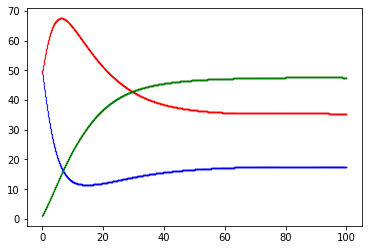

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_1649132905.png


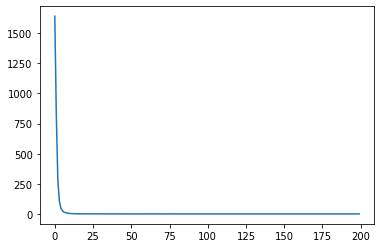

<Figure size 432x288 with 0 Axes>

In [ ]:
# SIS - Design D
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIS
model = SimpleNetworkSIS(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sis(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

using cuda
epoch = 200
epoch_step = 10
model_name = SimpleNetworkSIS
now_string = 2022-04-05-04-31-58
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy
Epoch [00010/00200] Loss:5.631307 Loss_1:0.620286 Loss_2:5.011021 Loss_3:0.000000 Lr:0.000990 Time:18.105077s (0.30min in total)
Epoch [00020/00200] Loss:0.732931 Loss_1:0.001460 Loss_2:0.731471 Loss_3:0.000000 Lr:0.000980 Time:19.640622s (0.63min in total)
Epoch [00030/00200] Loss:0.246524 Loss_1:0.000319 Loss_2:0.246205 Loss_3:0.000000 Lr:0.000971 Time:19.177369s (0.95min in total)
Epoch [00040/00200] Loss:0.037348 Loss_1:0.000042 Loss_2:0.037306 Loss_3:0.000000 Lr:0.000962 Time:18.565581

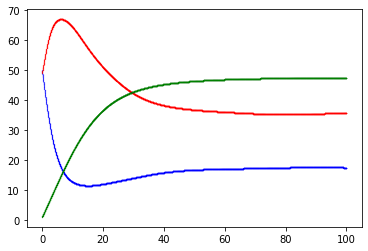

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_1649133302.png


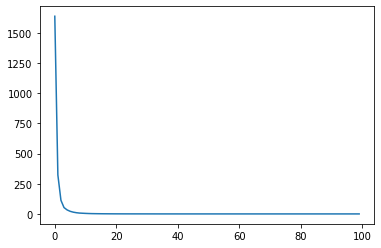

Epoch [00110/00200] Loss:0.001332 Loss_1:0.000002 Loss_2:0.001330 Loss_3:0.000000 Lr:0.000901 Time:12.406436s (3.27min in total)
Epoch [00120/00200] Loss:0.001329 Loss_1:0.000004 Loss_2:0.001325 Loss_3:0.000000 Lr:0.000893 Time:11.614854s (3.47min in total)
Epoch [00130/00200] Loss:0.001329 Loss_1:0.000006 Loss_2:0.001324 Loss_3:0.000000 Lr:0.000885 Time:9.250310s (3.62min in total)
Epoch [00140/00200] Loss:0.001328 Loss_1:0.000006 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000877 Time:9.061673s (3.77min in total)
Epoch [00150/00200] Loss:0.001328 Loss_1:0.000005 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000870 Time:8.065998s (3.91min in total)
Epoch [00160/00200] Loss:0.001328 Loss_1:0.000005 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000862 Time:10.895294s (4.09min in total)
Epoch [00170/00200] Loss:0.001327 Loss_1:0.000004 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000855 Time:11.236281s (4.28min in total)
Epoch [00180/00200] Loss:0.001325 Loss_1:0.000003 Loss_2:0.001322 Loss_3:0.000000 Lr:0.000847 Time:8

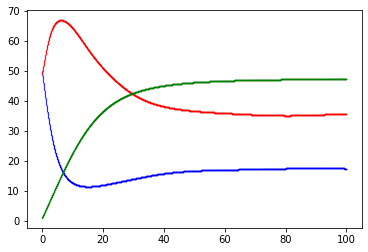

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_1649133401.png


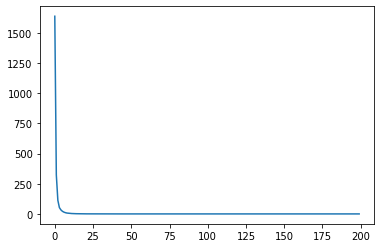

<Figure size 432x288 with 0 Axes>

In [ ]:
# SIS - Design A
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIS
model = SimpleNetworkSIS(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sis(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

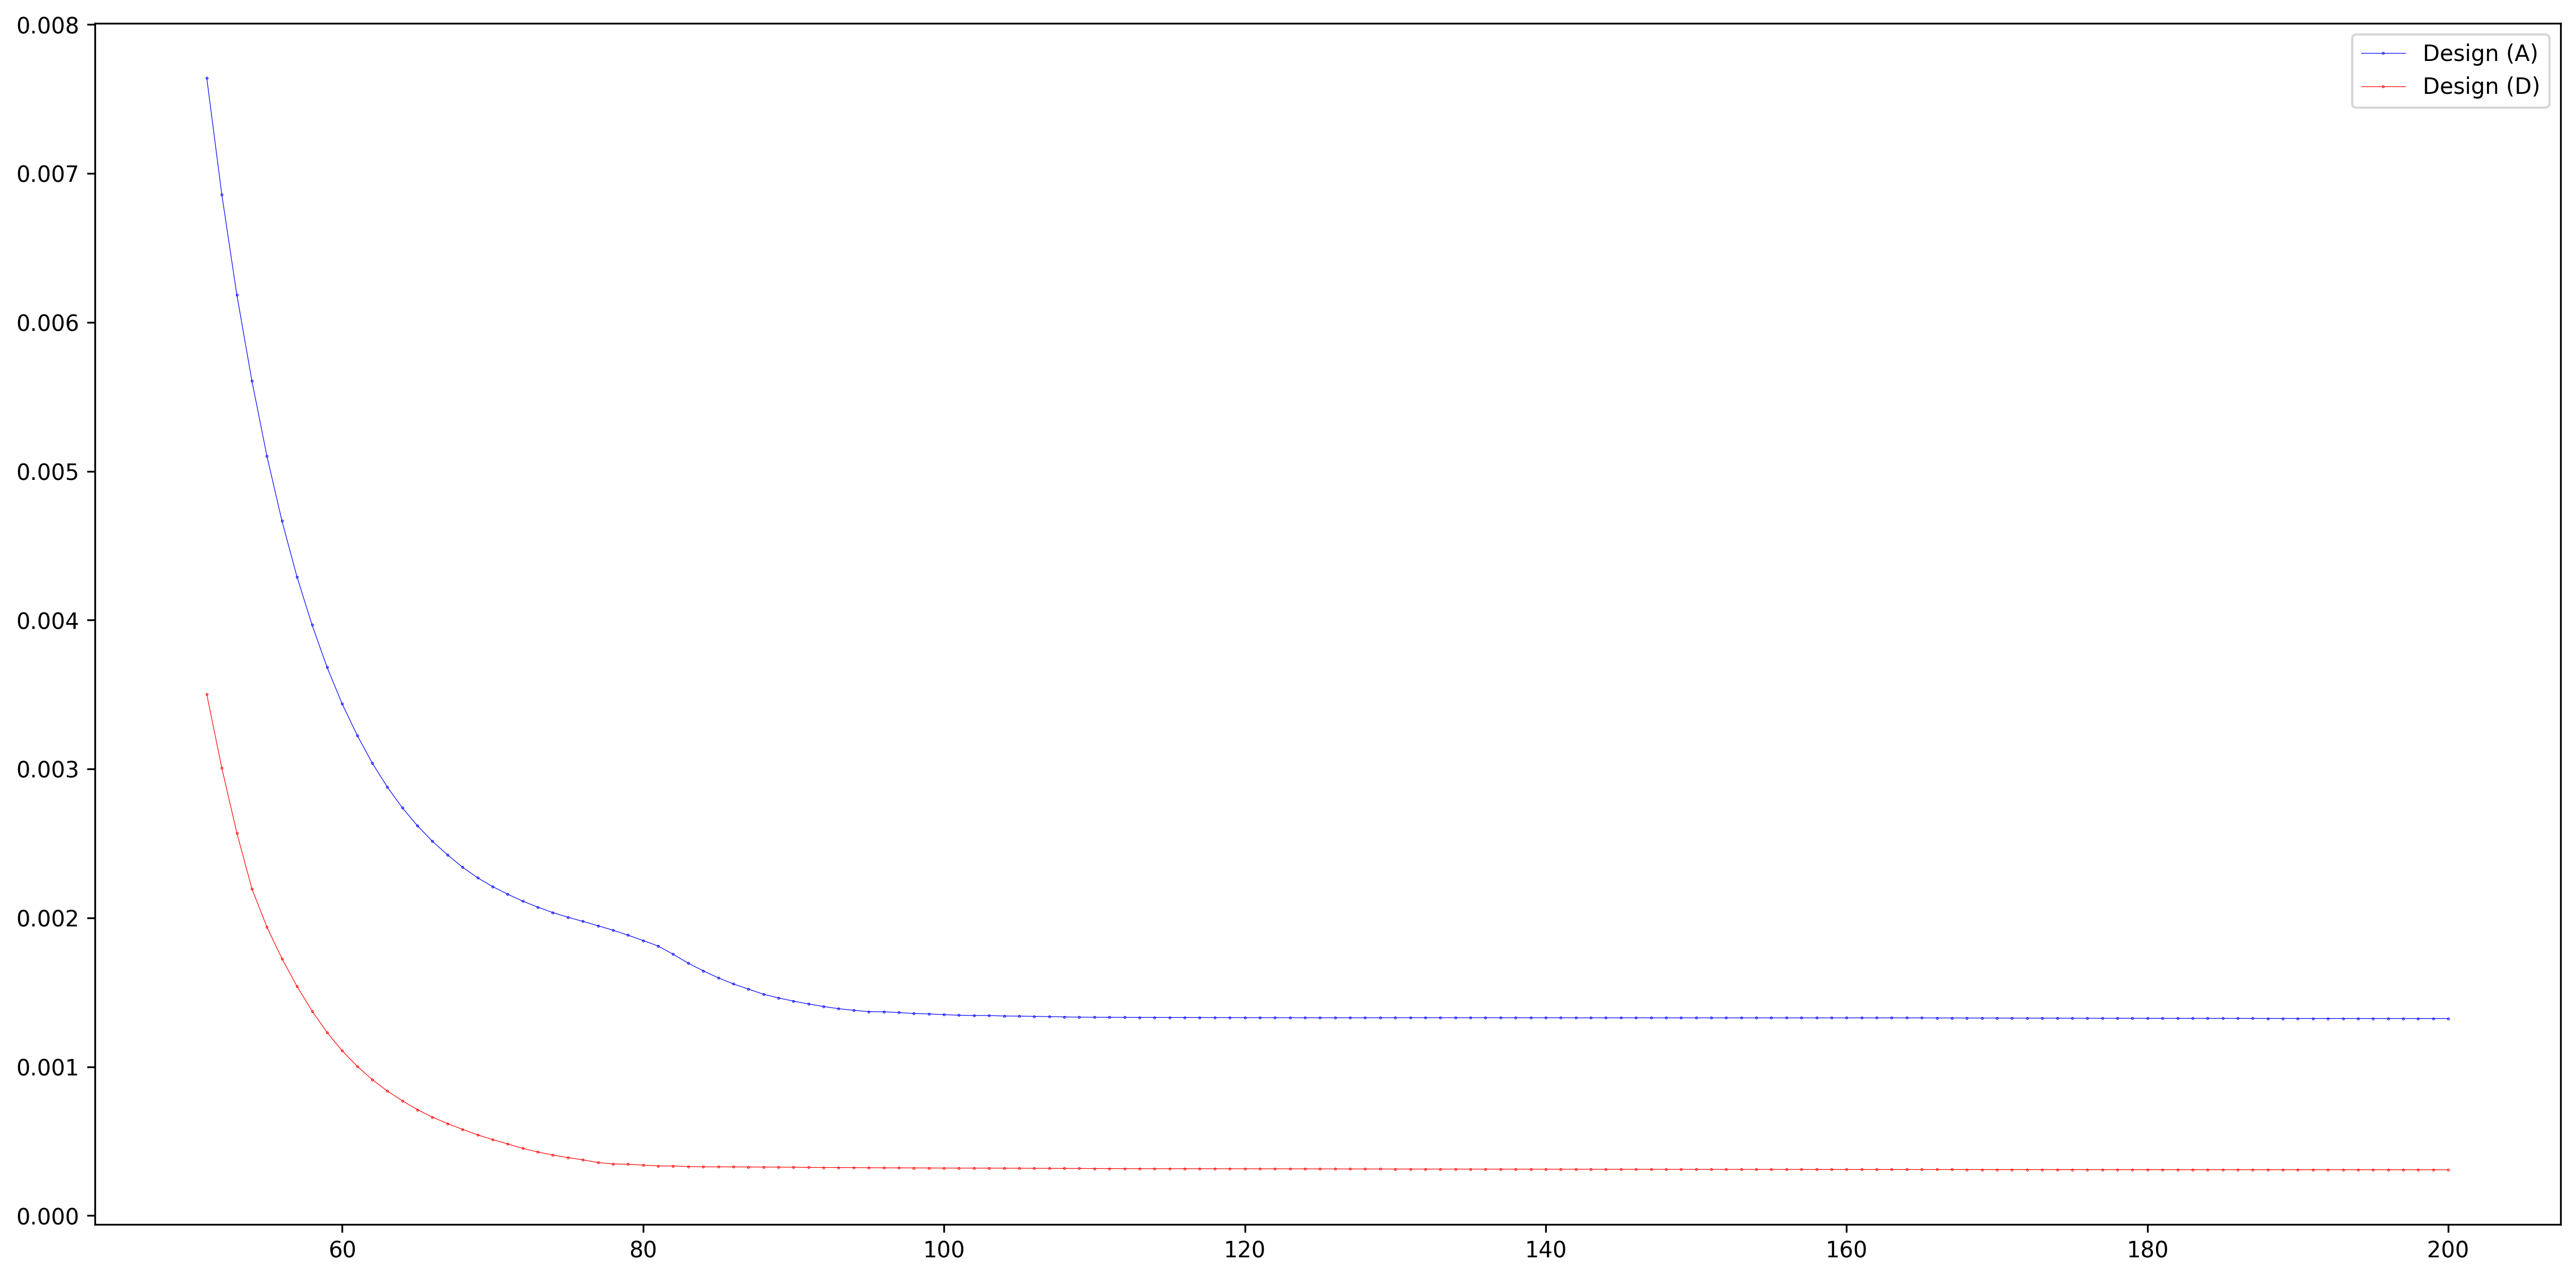

<Figure size 432x288 with 0 Axes>

In [4]:
# loss
import numpy as np
loss_a = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy")
loss_d = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy")

start = 50
end = len(loss_a)
x = range(start + 1, end + 1)
plt.figure(dpi=300, figsize=[20,10])
plt.plot(x, loss_a[start:], marker='.', markersize=0.5, linewidth=0.3, c="b")
plt.plot(x, loss_d[start:], marker='.', markersize=0.5, linewidth=0.3, c="r")
plt.legend(["Design (A)","Design (D)"])
plt.show()
plt.clf()